In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from os import path
import sys
sys.path.append(path.join(".."))

import saly
import saly.backend as S
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

EPOCHS = 6
SPECIES = 'Mouse'
DATA_PATH = '/home/mlongar/Data/SingleCellGeneExpression/'
DATASET_HRVATIN_PATH = DATA_PATH + 'hrvatin_2018.h5ad' 
DATASET_CHEN_PATH = DATA_PATH + 'chen_2017.h5ad'
DATASET_ZHENG_PATH = DATA_PATH + '10x_mouse_1.3mln.h5ad'
MARKER_PATH = DATA_PATH + 'panglao_gene_markers.tab.gz'

Using TensorFlow backend.


In [2]:
hrvatin_data = saly.load_h5ad(DATASET_HRVATIN_PATH)
print("HRVATIN DATA\n", hrvatin_data.shape)

HRVATIN DATA
 (48266, 25186)


In [3]:
chen_data = saly.load_h5ad(DATASET_CHEN_PATH)
print("CHEN DATA\n", chen_data.shape)

CHEN DATA
 (14437, 23284)


In [4]:
zheng_data = saly.load_h5ad(DATASET_ZHENG_PATH)
print("ZHENG DATA\n", zheng_data.shape)

ZHENG DATA
 (1306127, 27932)


In [5]:
chen_data = saly.drop_rows(chen_data, ['tanycyte', 'unknown', 'ependymal cell', 'epithelial cell'])

Dropped 4750 cell(s). New shape: (9687, 23284)


In [6]:
markers_db = saly.load_markers(MARKER_PATH, SPECIES)
markers = saly.get_mutual_markers([hrvatin_data, chen_data, zheng_data], markers_db)
print('Mutual markers:', len(markers))

Mutual markers: 7382


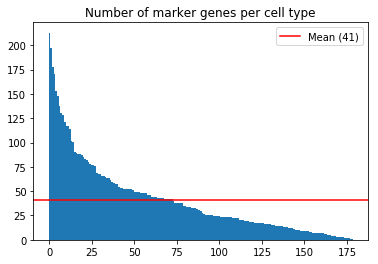

In [7]:
saly.plot_marker_genes(markers)

In [8]:
marker_aliases = {'Neuron' : 'Neurons',
                'Oligodendrocyte' : 'Oligodendrocytes',
                'Muscle cell' : 'Smooth muscle cells',
                'Endothelial cell' : 'Endothelial cells',
                'Astrocyte' : 'Astrocytes',
                'Macrophage' : 'Macrophages',
                'OPC' : 'Oligodendrocyte progenitor cells',
                'Pericyte' : 'Pericytes'}

saly.check_labels([hrvatin_data, chen_data], markers, marker_aliases)

In [9]:
hrvatin_data = saly.drop_unused_genes(hrvatin_data, markers)
chen_data = saly.drop_unused_genes(chen_data, markers)
zheng_data = saly.drop_unused_genes(zheng_data, markers)

saly.check_shape([hrvatin_data, chen_data, zheng_data])

Dropped 21107 gene(s). New shape: (48266, 4079)
Dropped 19205 gene(s). New shape: (9687, 4079)
Dropped 23853 gene(s). New shape: (1306127, 4079)


In [10]:
zheng_data = saly.mark_as_unlabelled(zheng_data.copy())

In [11]:
train_data, _, _ = saly.preprocess_data(zheng_data, splits=10,
                                       train=1, test=0, validation=0)

In [12]:
chen_data = S.normalize_data(chen_data.copy())
hrvatin_data = S.normalize_data(hrvatin_data.copy())

In [13]:
model, marker_model, encoder_model = saly.build_model(train_data, markers, supervised=False);

In [18]:
history = saly.train_model(model, train_data, markers, marker_aliases,
                           2, validation_data=chen_data, verbose=1)

Train on 1306127 samples, validate on 9687 samples
Epoch 1/2
1306127/1306127 [==============================] - 96s 74us/step - loss: 2008.2017 - cell_activations_loss: 0.0000e+00 - output_loss: 2.0082 - cell_activations_celltype_accuracy: 0.0000e+00 - val_loss: 2905.0479 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 2.9050 - val_cell_activations_celltype_accuracy: 0.8798
Epoch 2/2
1306127/1306127 [==============================] - 95s 73us/step - loss: 2006.2162 - cell_activations_loss: 0.0000e+00 - output_loss: 2.0062 - cell_activations_celltype_accuracy: 0.0000e+00 - val_loss: 2907.0453 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 2.9070 - val_cell_activations_celltype_accuracy: 0.8916


In [15]:
chen_baseline = saly.get_baseline(chen_data, markers)
validation_baseline = saly.get_results(chen_data.obs['labels'], chen_baseline.X.toarray(), markers, marker_aliases)

Correct predictions: 6623 out of 9687 (68.37%)
	Neuron: 42.07% (974/2315) | Markers: 197
	Oligodendrocyte: 77.15% (2732/3541) | Markers: 85
	OPC: 95.48% (1711/1792) | Markers: 28
	Astrocyte: 57.4% (659/1148) | Markers: 61
	Microglia: 70.99% (514/724) | Markers: 80
	Macrophage: 19.76% (33/167) | Markers: 130


In [16]:
hrvatin_baseline = saly.get_baseline(hrvatin_data, markers)
saly.get_results(hrvatin_data.obs['labels'], hrvatin_baseline.X.toarray(), markers, marker_aliases);

Correct predictions: 25021 out of 48266 (51.84%)
	Neuron: 10.37% (1579/15223) | Markers: 197
	Oligodendrocyte: 63.82% (5508/8630) | Markers: 85
	Muscle cell: 0.0% (0/621) | Markers: 77
	Astrocyte: 75.72% (5330/7039) | Markers: 61
	Endothelial cell: 50.61% (1746/3450) | Markers: 178
	Macrophage: 1.68% (9/537) | Markers: 130
	Microglia: 89.09% (9050/10158) | Markers: 80
	OPC: 97.81% (1786/1826) | Markers: 28
	Pericyte: 1.66% (13/782) | Markers: 64


In [19]:
chen_cell_activations = marker_model.predict(chen_data.X)
saly.get_results(chen_data.obs['labels'], chen_cell_activations, markers, marker_aliases);

Correct predictions: 8637 out of 9687 (89.16%)
	Neuron: 99.7% (2308/2315) | Markers: 197
	Oligodendrocyte: 97.6% (3456/3541) | Markers: 85
	OPC: 91.02% (1631/1792) | Markers: 28
	Astrocyte: 76.31% (876/1148) | Markers: 61
	Microglia: 33.7% (244/724) | Markers: 80
	Macrophage: 73.05% (122/167) | Markers: 130


In [20]:
hrvatin_cell_activations = marker_model.predict(hrvatin_data.X)
saly.get_results(hrvatin_data.obs['labels'], hrvatin_cell_activations, markers, marker_aliases);

Correct predictions: 36499 out of 48266 (75.62%)
	Neuron: 99.99% (15221/15223) | Markers: 197
	Oligodendrocyte: 90.85% (7840/8630) | Markers: 85
	Muscle cell: 0.0% (0/621) | Markers: 77
	Astrocyte: 95.38% (6714/7039) | Markers: 61
	Endothelial cell: 100.0% (3450/3450) | Markers: 178
	Macrophage: 86.96% (467/537) | Markers: 130
	Microglia: 2.22% (226/10158) | Markers: 80
	OPC: 99.07% (1809/1826) | Markers: 28
	Pericyte: 98.72% (772/782) | Markers: 64


# Analysis

../saly/backend/analysis.py:105: RuntimeWarning: invalid value encountered in true_divide
  recall = tp / (tp + fn)
/home/mlongar/miniconda/envs/MG/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


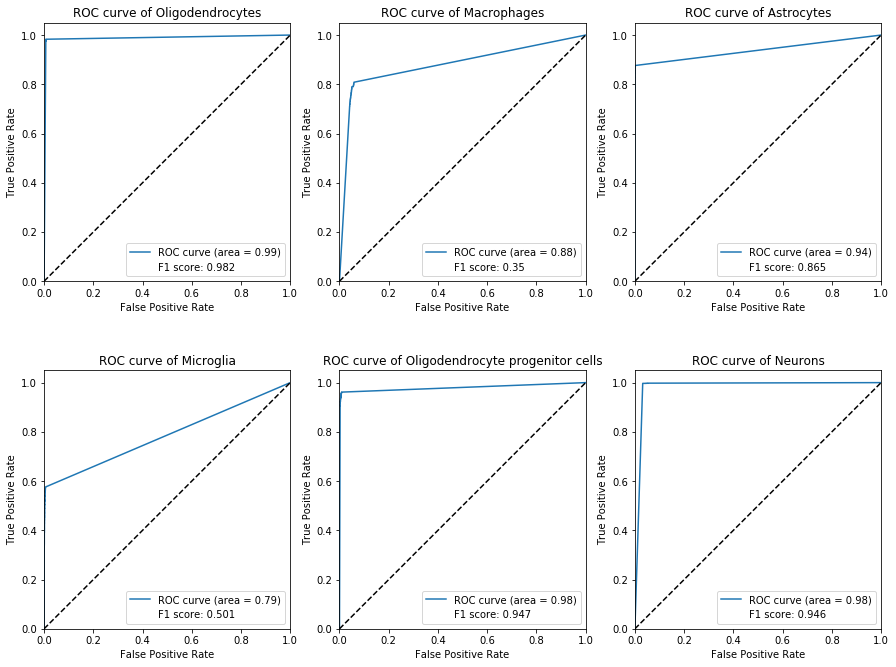

In [21]:
saly.draw_roc(chen_data.obs['labels'], chen_cell_activations, markers, marker_aliases)

../saly/backend/analysis.py:104: RuntimeWarning: invalid value encountered in true_divide
  precision = tp / (tp + fp)


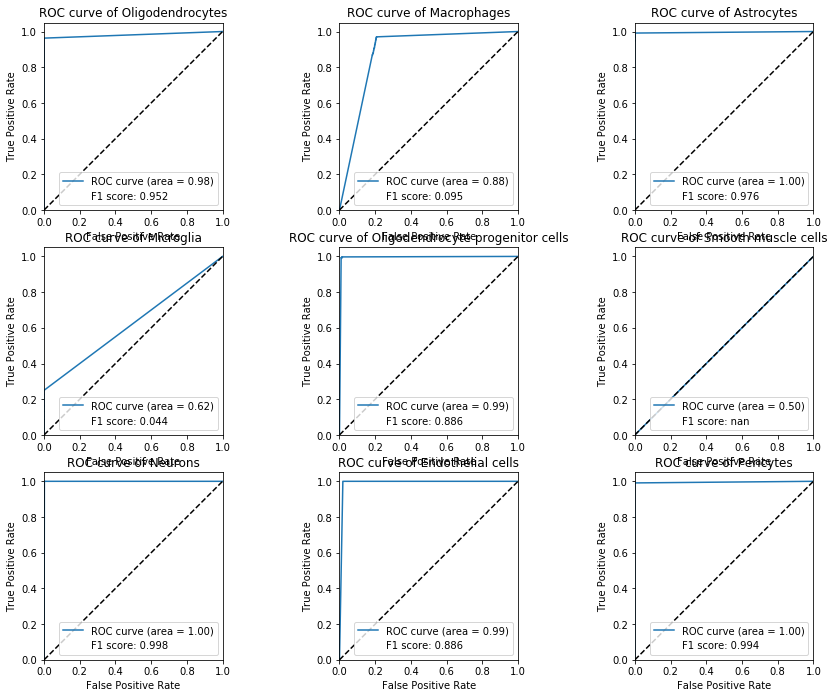

In [22]:
saly.draw_roc(hrvatin_data.obs['labels'], hrvatin_cell_activations, markers, marker_aliases)